# Binary Classification of Insurance Cross Selling
- **Projet kaggle disponible sur : https://www.kaggle.com/competitions/playground-series-s4e7**

* **objectif :** L'objectif de ce concours est de prédire quels clients répondent positivement à une offre d'assurance automobile.

# Plan : 
## 1. Connaissance du jeu de données:
- Features signification
- Données manquantes ?
- Type de target ?
- Type de données ? 
## 2. Dataviz 
- Analyse univariée
    - Visualisation des variables continues & test de shapiro (normalité)
    - visualisation des variables discrètes & qualitatives
    - visualisation de la target
    
- Analyse bivariée : Target Vs features
    - Target vs variables continues
    - Target vs variables qualitatives/discrètes
- Analyse multivariée

## 3. Test statistique
- Target vs variable continues
- Target vs variables discretes + qualitatives
## 4. Preprocessing
- Standardisation des variables continues
- Encodage des variables qualitatives

In [658]:
import pickle
# ^^^ pyforest auto-imports - don't write above this line
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from scipy.stats import chi2_contingency, kruskal, pearsonr, shapiro, levene, mannwhitneyu, spearmanr
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler , LabelEncoder

from termcolor import colored
import os
import warnings
warnings.filterwarnings('ignore')

In [659]:
path_train = r"D:\Etude_Data_science\Kaggle_competition\08_Binary_Classification_of_Insurance_Cross_Selling\dataset\train.csv"

In [660]:
train = pd.read_csv(path_train)

In [661]:
data = train.copy()

In [662]:
data.shape

(11504798, 12)

Le dataframe de base étant très volumineux (ordre de 10^7, nous allons prendre le 1/100è du jeu de données afin d'alléger les calculs de la machine) 

In [663]:
df = data

In [664]:
print(colored("Dimensions :",color="blue", attrs = ["bold"]), df.shape)
df.head()

Dimensions : (11504798, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [665]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   Gender                object 
 2   Age                   int64  
 3   Driving_License       int64  
 4   Region_Code           float64
 5   Previously_Insured    int64  
 6   Vehicle_Age           object 
 7   Vehicle_Damage        object 
 8   Annual_Premium        float64
 9   Policy_Sales_Channel  float64
 10  Vintage               int64  
 11  Response              int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 1.0+ GB


### Features signification : 
- **Driving_License**: Permis de conduire
-  **Region_Code**: Code de la région
- **Previously_Insured**: Précédemment assuré
- **Vehicle_Age**: Âge du véhicule
- **Vehicle_Damage**: Dommages au véhicule
- **Annual_Premium**: Prime annuelle
- **Policy_Sales_Channel**: Canal de vente de la police	
- **Vintage**: Ancienneté du véhicule

### Données manquantes : Non

### Target : Classification binaire

### Type de données :
- Vehicle_Age à changer en type category

In [666]:
df['Vehicle_Age'] = df['Vehicle_Age'].astype('category')
df['Gender'] = df['Gender'].astype('category')
df['Vehicle_Damage'] = df['Vehicle_Damage'].astype('category')

In [667]:
df.select_dtypes("category").nunique()

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
dtype: int64

In [668]:
df.Vehicle_Age.head()
#Changeons l'ordre des catégories

0     1-2 Year
1    > 2 Years
2     < 1 Year
3     1-2 Year
4     1-2 Year
Name: Vehicle_Age, dtype: category
Categories (3, object): ['1-2 Year', '< 1 Year', '> 2 Years']

In [669]:
# Mettons les catégories dans l'ordre souhaité :
categories = ['< 1 Year', '1-2 Year', '> 2 Years']
# A l'aide de Categorical de pandas, nous pouvons appliquer l'ordre souhaitée :
df['Vehicle_Age'] = pd.Categorical(df['Vehicle_Age'], categories=categories, ordered=True)

In [670]:
df.Vehicle_Age.head()

0     1-2 Year
1    > 2 Years
2     < 1 Year
3     1-2 Year
4     1-2 Year
Name: Vehicle_Age, dtype: category
Categories (3, object): ['< 1 Year' < '1-2 Year' < '> 2 Years']

## 2. Data visualisation
### Analyse univariée

In [671]:
df.dtypes

id                         int64
Gender                  category
Age                        int64
Driving_License            int64
Region_Code              float64
Previously_Insured         int64
Vehicle_Age             category
Vehicle_Damage          category
Annual_Premium           float64
Policy_Sales_Channel     float64
Vintage                    int64
Response                   int64
dtype: object

Pour attribuer correctement les variables continues des variables discrètes, nous allons regarder le nunique (nombre de modalités prises) pour les variables de type int et float, si la variable prend beaucoup de modalité on la considèrera comme continue, sinon comme discrète
- On va faire un choix arbitraire, par exemple si on prend plus de 20 valeurs différentes on considère que la variable est continue, sinon discrète (on modifiera  la condition si dans la partie data visualisation on voit que ca ne va pas)

In [672]:
var_num = df.select_dtypes(exclude="category").columns.tolist()

In [673]:
var_cont, var_dis =  [],[]
for i in var_num[1:]:
    col = df[i]
    if df[i].nunique()>60: #si supérieur, alors variable continue
        print(f"{colored(i,'blue'):-<30} : {colored(col.nunique(),'green')} ({col.dtypes})")
        var_cont.append(i)
    else:#sinon variable discrète
        print(f"{colored(i,'blue'):-<30} : {colored(col.nunique(),'red')}")
        var_dis.append(i)

Age------------------ : 66 (int64)
Driving_License------ : 2
Region_Code---------- : 54
Previously_Insured--- : 2
Annual_Premium------- : 51728 (float64)
Policy_Sales_Channel- : 152 (float64)
Vintage-------------- : 290 (int64)
Response------------- : 2


In [674]:
df.Policy_Sales_Channel.unique()

array([124.,  26., 152., 156., 160.,   8.,  31., 157.,  60., 122.,  15.,
        30., 147.,   1.,  63., 136., 154.,  18., 135., 151.,   3.,  10.,
        55., 108.,   7.,  29., 163.,  13., 133., 145.,  25.,  12., 109.,
        23.,  78.,   4., 153., 150., 146., 120., 107., 155.,  61.,  14.,
        45.,  11.,  19.,  24.,  52., 132., 125.,  59.,  16.,  22.,  56.,
        20., 148., 158., 159., 139.,   9., 113., 121.,  21., 111.,  64.,
       116., 103., 128.,  65.,  37.,  91., 129., 127., 106., 140.,  35.,
       131.,  17.,  93.,  90.,  36., 118.,  54.,  62., 138.,  42.,  46.,
        86.,  80.,  68., 119.,  94.,  48.,  47.,  83.,  97.,  70.,  53.,
        44., 114.,  98.,  88., 110.,  32., 126.,  96.,  99., 130.,  66.,
       105.,  51.,  38., 137.,  89.,  81.,  92., 117.,  73.,  69.,  49.,
        87.,  33.,  39.,  50., 123.,  75., 101., 115., 100.,  95.,  57.,
        71., 134.,  82.,   6.,  58., 104.,  41.,  40.,   2.,  79.,  34.,
        76.,  28.,  74.,  43.,  67.,  27., 112., 10

- Les 3 variables n'ayant que deux modalités, il ne fait aucun doute qu'on les considèrera comme discrète
- Il ne reste plus qu'a récupérer les variable qualitatives

In [675]:
#séparation des données en fonction de leur type : 
var_qual = df.select_dtypes("category").columns.tolist()

Passons a la visualisation :
### Variable continues



In [676]:
def visualisation_plot(columns, nrow,ncol):
    plt.figure(figsize=(22,20))
    for i, column in enumerate(list(df[columns].columns), 1):
        plt.subplot(nrow,ncol,i)
        ax=sns.histplot(x=column,data=df,kde=True,color="orange")
        ax.axvline(df[column].mean(), c = "red", label = "Moyenne")
        ax.axvline(df[column].median(), c = "yellow", label = "Mediane")
        ax.legend()

    plt.show()

In [677]:
def shapiro_test(list_col):
    """
    Cette fonction teste si list_col est une liste, si ce n'est pas le cas,
    elle convertie le texte en une liste avant de faire un test shapiro pour vérifier
    si la feature suit une loi normale ou non
    """
    if type(list_col) != list:
        list_col = [list_col]

    accepted,rejected = [], []

    for col in df[list_col]:
        stat, p_value = shapiro(df[col])  
        alpha = 0.05
        if p_value > alpha: 
            result = colored('Accepter', 'green')  
            accepted.append(col)
        else:
            result = colored('Rejet','red')        
            rejected.append(col)

        print(f'{col:-<50}\t Hypothèse: {result}')
    return accepted,rejected

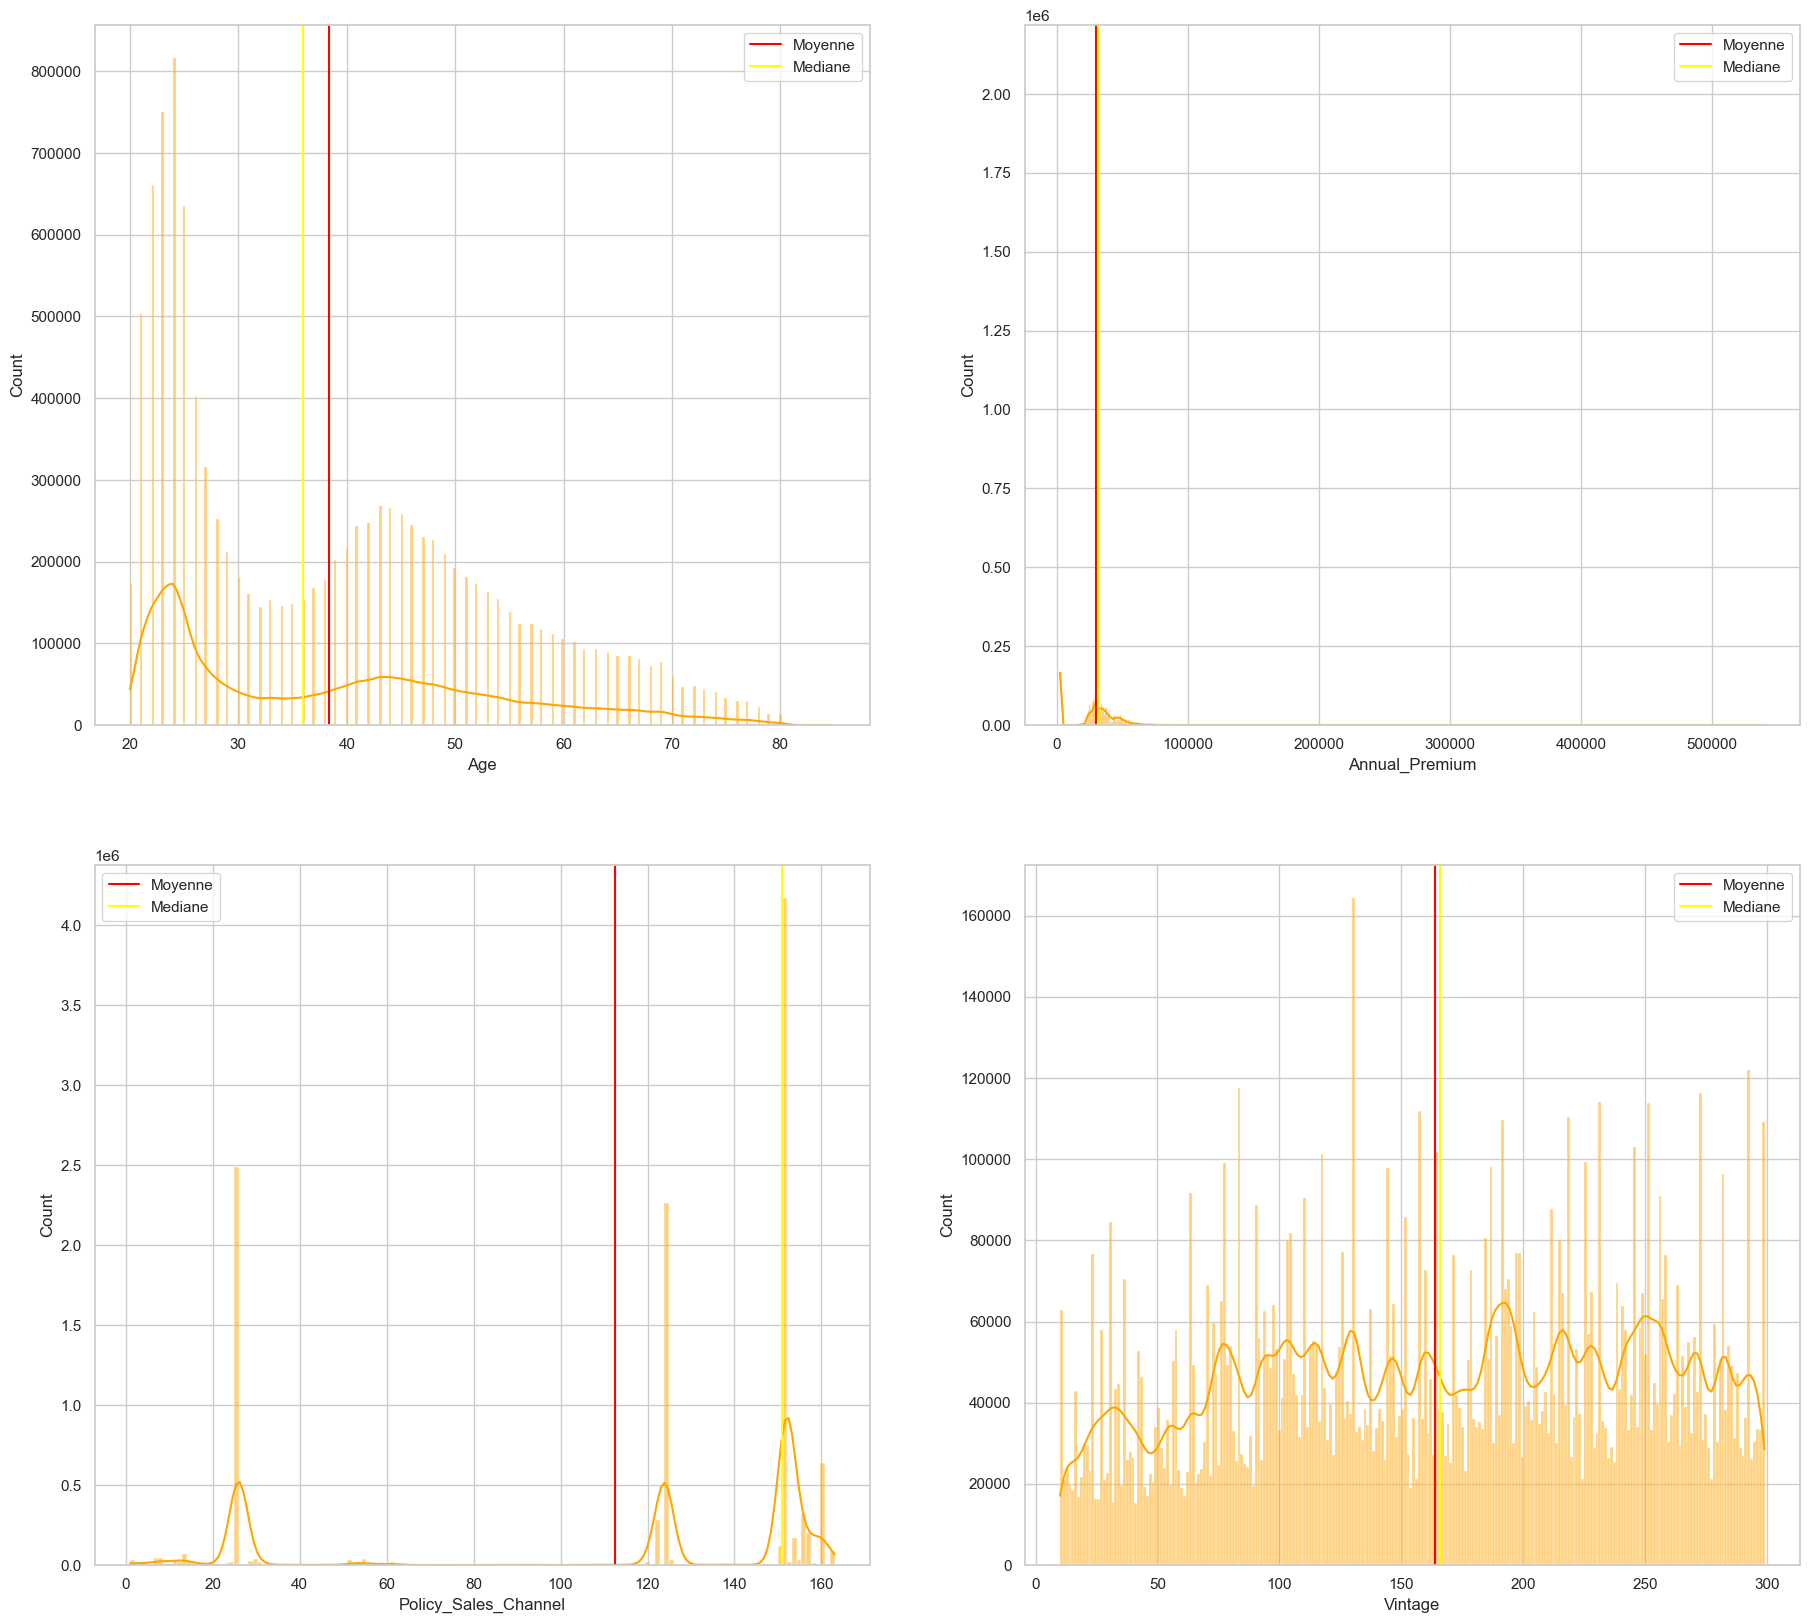

In [678]:
visualisation_plot(var_cont,2,2)

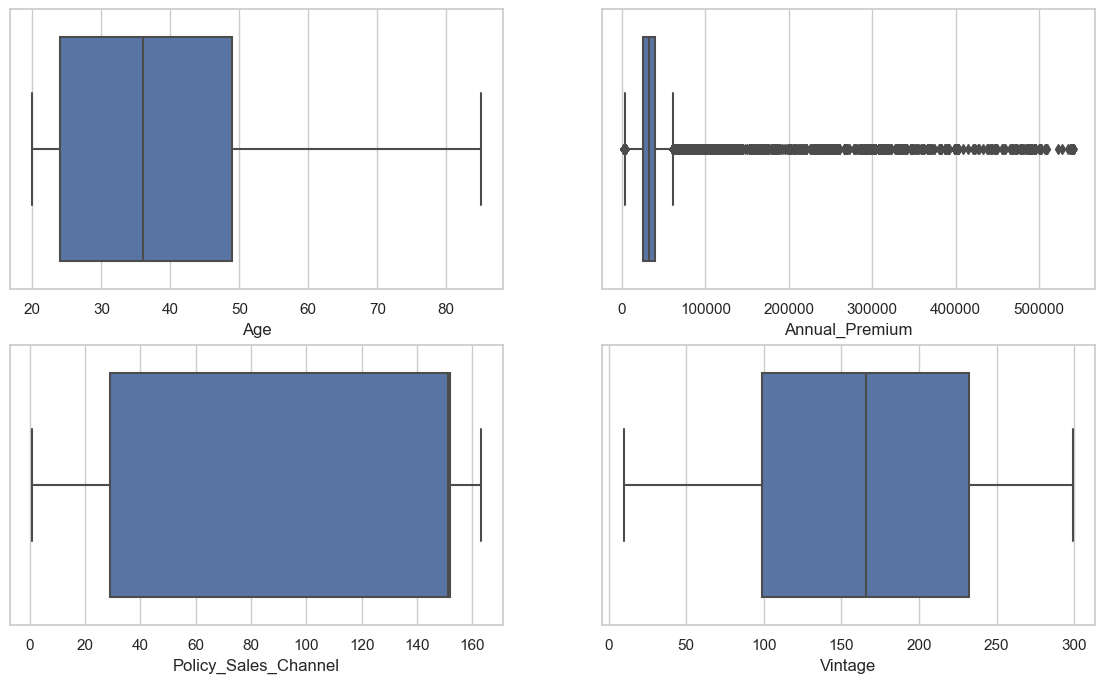

In [679]:
plt.figure(figsize=(14,8))
for i, column in enumerate(list(df[var_cont].columns), 1):
    plt.subplot(2,2,i)
    sns.boxplot(data=df[var_cont],x=column)

A la visualisation de ces figures, on peut remarquer que pour la variable annual_premium nous avons une observation qui est très loin devant les autres, nous allons la supprimer pour améliorer la visibilité

In [680]:
#Récupération de la ligne a supprimer avec le mask :
mask = df.Annual_Premium>350000
#On prend l'inverse car on souhaite conservée toutes les lignes sauf celle du mask :
mask = ~mask
df = df[mask]

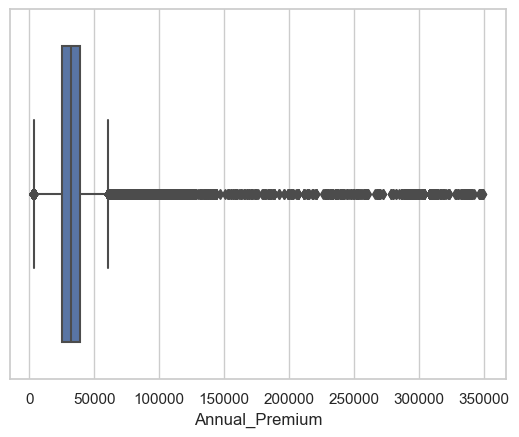

In [681]:
sns.boxplot(data=df[var_cont],x='Annual_Premium')
plt.show()

### Variables discrètes

In [682]:
def discret_plot_viz(columns,nrow,ncol):
    plt.figure(figsize=(14,10))
    for i, column in enumerate(list(df[columns].columns), 1):
        plt.subplot(nrow,ncol,i)
        ax=sns.countplot(y=column,data=df, )
    plt.show()

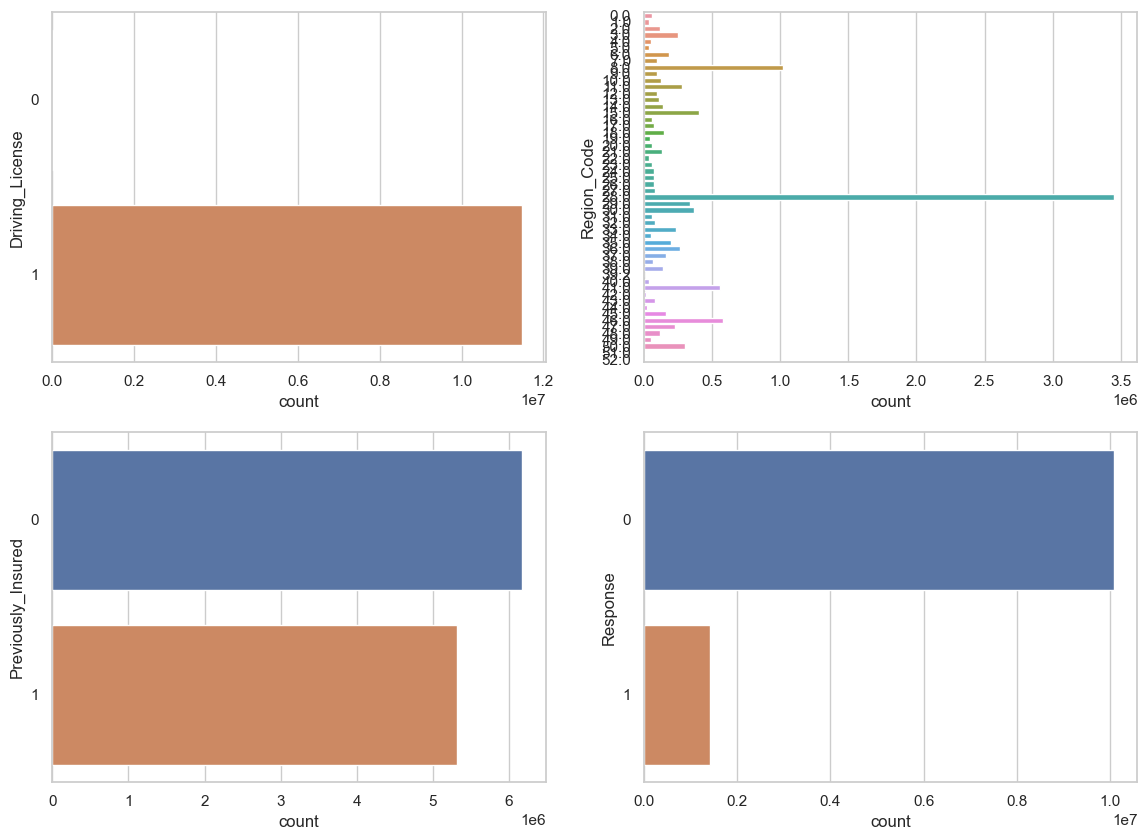

In [683]:
discret_plot_viz(var_dis,2,2)

- On peut voir que dans la feature driving_licence, tout le monde possède son permis (100% de 1) ce qui est logique car il faut avoir un permis pour pouvoir demander une assurance
- Comme nous avons uniquement prit une fraction du jeu de données, peut être que dans son ensemble on pourrait trouver des individus qui n'ont pas de permis et qui veulent souscrire une assurance
- Sinon, ici, comme il n'y a pas de variation de l'information avec une unique modalité, on peut supprimer la colonne

In [684]:
var_dis.remove('Driving_License')

### Variables qualitatives

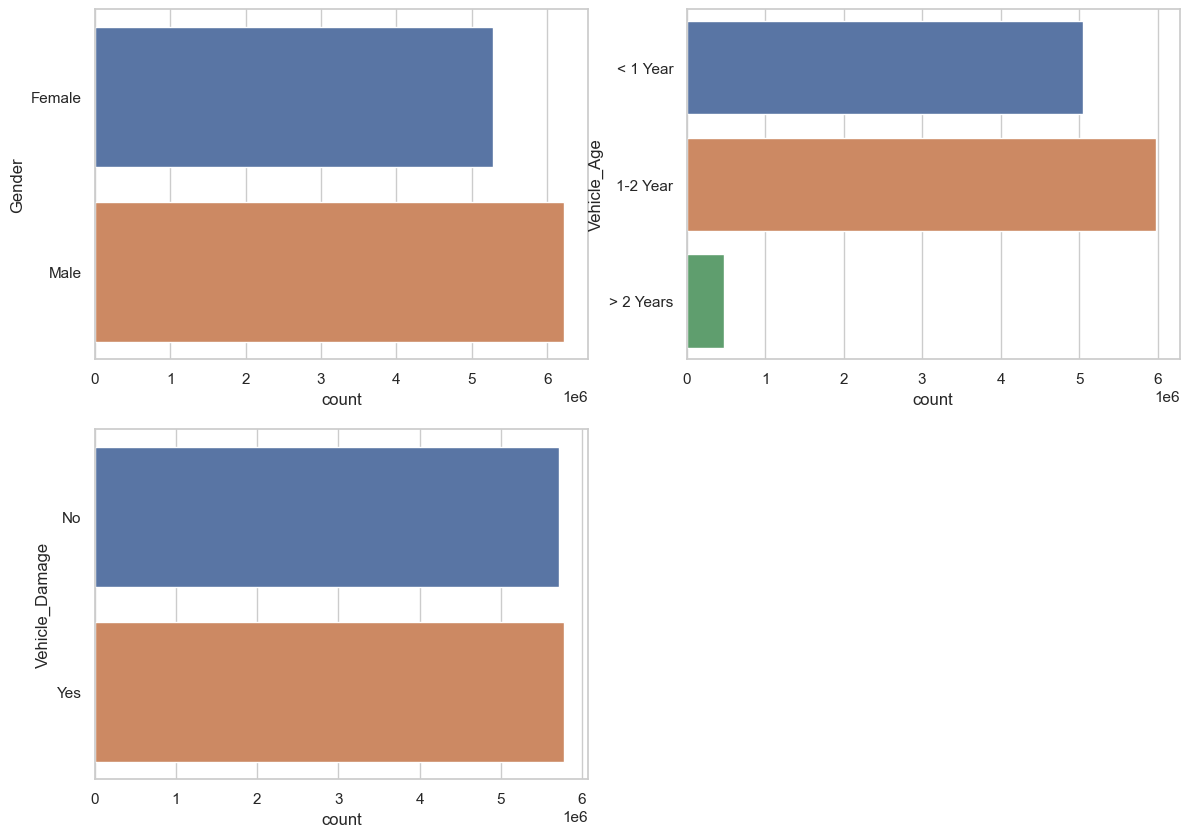

In [685]:
discret_plot_viz(var_qual,2,2)

### Target :

In [686]:
prop_targ = df.Response.value_counts(normalize=True)

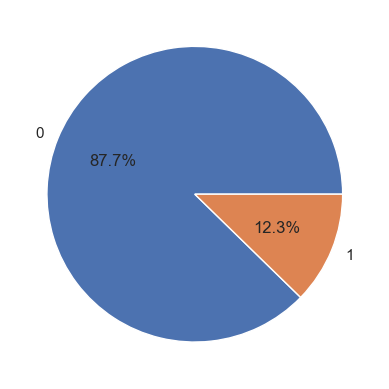

In [687]:
plt.pie(prop_targ.values, labels=prop_targ.keys(), autopct='%1.1f%%' )
plt.show()

### on peut observer qu'il y a un vrai déséquilibre de classe, il faudra utiliser le stratify lors de la séparation en train et test set pour rééquilibrer la target pour la phase d'apprentissage des modèles

## Analyse  bivariée : 
#### Target Vs variables continues

In [688]:
def boxplot2(columns,nrow,ncol):
    plt.figure(figsize=(14,10))
    for i,col in enumerate(columns,1):
        plt.subplot(nrow,ncol,i)
        sns.boxplot(x=df.Response, y = col, data = df[var_cont])

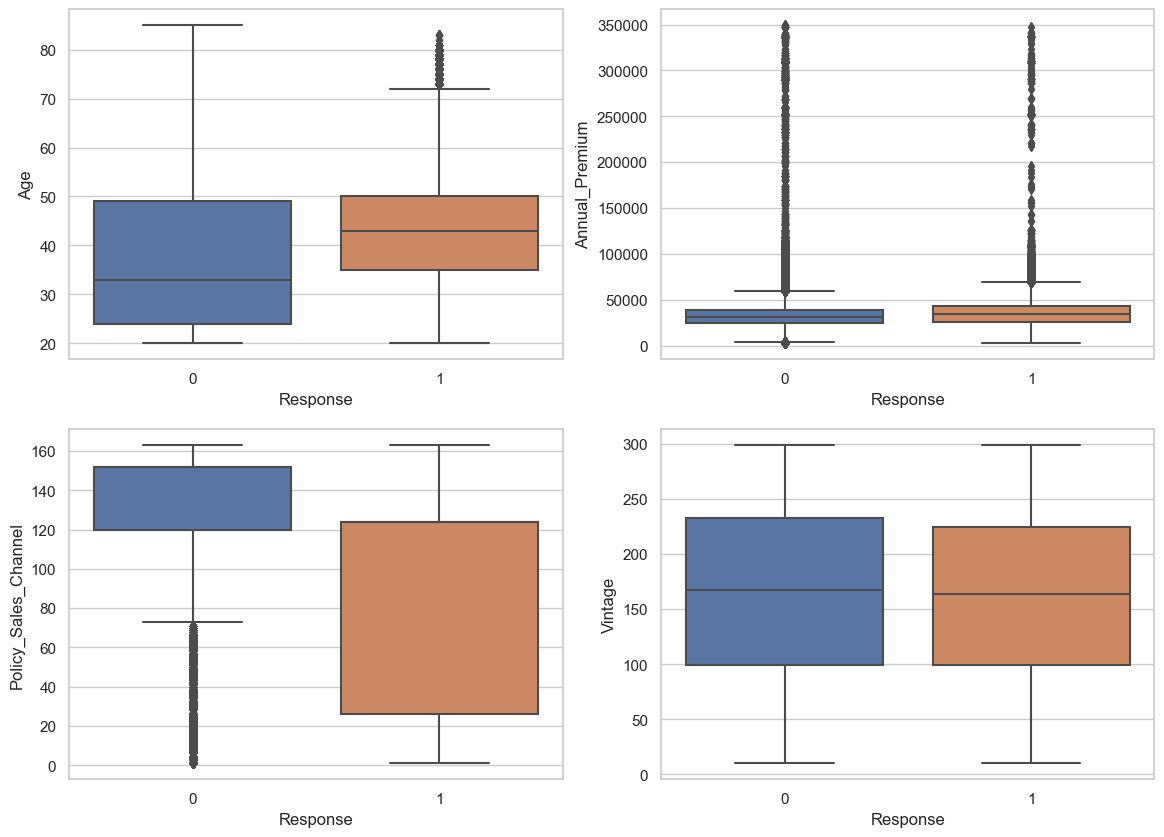

In [689]:
boxplot2(var_cont,2,2)

In [690]:
df[var_cont+list(['Response'])].groupby("Response").mean()

,Age,Annual_Premium,Policy_Sales_Channel,Vintage
Response,,,,
0,37.69758,30248.044512,115.516900,164.352179
1,43.27322,31849.608670,90.388318,160.656958


#### Target Vs variables discrètes & qualitatives

In [691]:
#rassemblons les variables discrètes et qualitatives : 
var_cat = var_dis + var_qual

In [692]:
def barplot2(feat,target, stacked=False):
    """
    Fonction permettant d'obtenir un barplot en fonction de 2 variables
    La normalisation se fait en fonction de la variable 'target'
     ON PEUT NORMALISER PAR LA FEATURE EN INVERSANT DANS LES PARAMETRES "feat" & "target"

    """
    # Calculer les comptages groupés
    grouped_counts = df.groupby([target,feat]).size().unstack()

    # Normalisation par "target"
    total_by_gender = grouped_counts.sum(axis=1)
    normalized_by_gender = grouped_counts.div(grouped_counts.sum(axis=1), axis=0) * 100

    #  graphique en barres empilées normalisé par la target
    ax1 = normalized_by_gender.plot(kind="bar", stacked=stacked)
    ax1.set_ylabel(f'Pourcentage (%) - Normalisé par {target}')
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.1f%%')
    plt.title(f'Normalisation par {target}')
    plt.show()

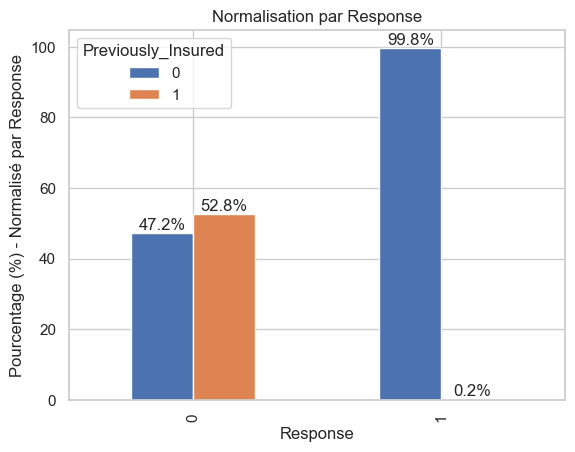

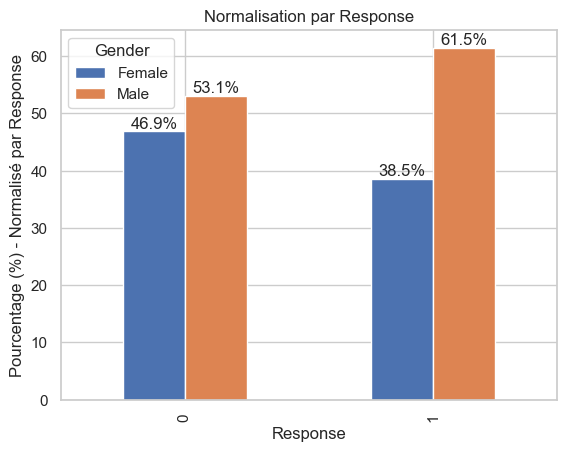

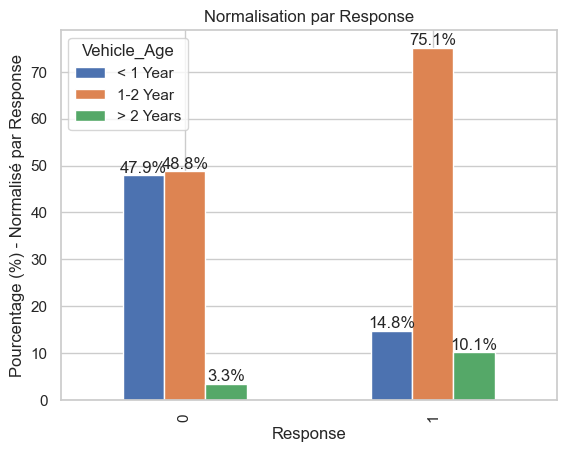

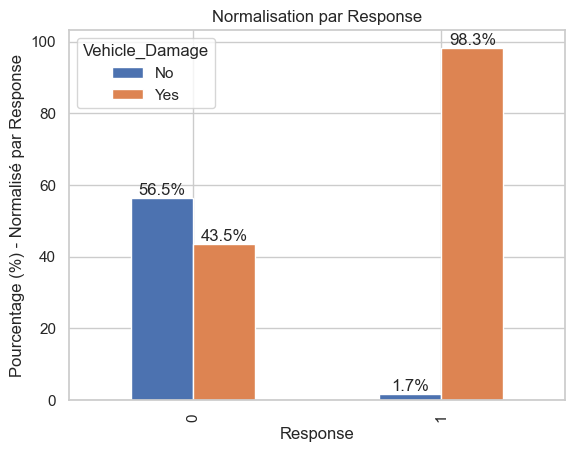

In [693]:
for i in var_cat:
    if (i !="Response") & (df[i].nunique()<10):
        barplot2(i,"Response",)

# Analyse multivariée : 

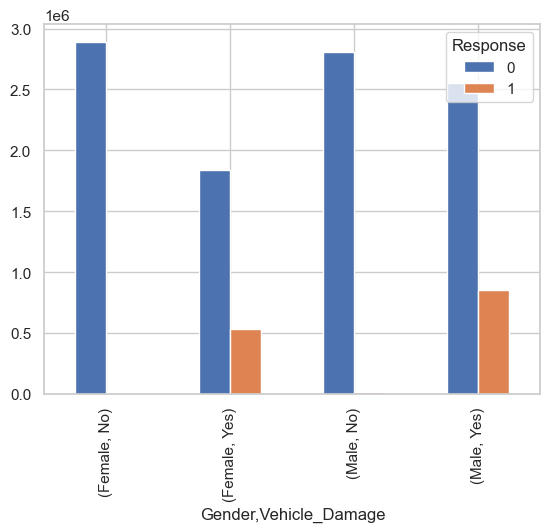

In [694]:
df[var_cat].groupby(["Gender","Vehicle_Damage","Response"]).size().unstack().plot(kind="bar", )
plt.show()

<Axes: xlabel='Gender'>

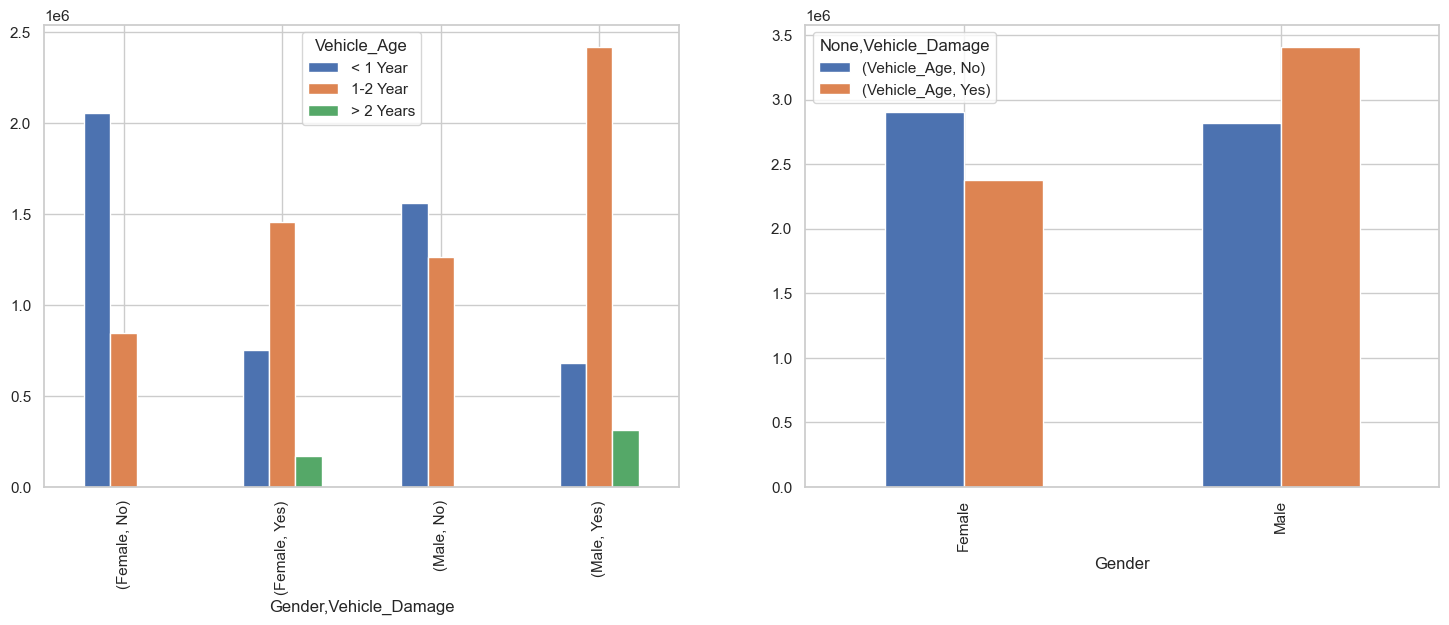

In [695]:
fig,axes = plt.subplots(1,2,figsize=(18,6))

df[var_qual].groupby(["Gender","Vehicle_Damage","Vehicle_Age"]).size().unstack().plot(kind="bar", ax=axes[0])
df[var_qual].groupby(["Gender","Vehicle_Damage"]).count().unstack().plot(kind="bar", ax=axes[1])

- Homme font plus d'accident que les femmes
- La majorité des accidents se situe après la 1ère année du véhicule

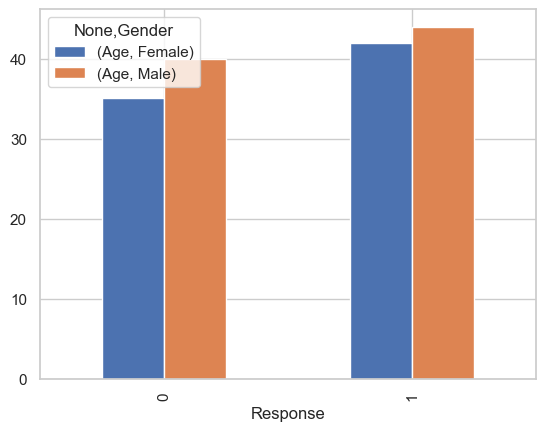

In [711]:
df[['Age', "Gender","Response"]].groupby(["Response","Gender"]).mean().unstack().plot(kind="bar")
plt.show()

## 3. Test statistique
#### Target vs variable continues : **Test de Man Withney**

Le choix de ce test statistique est justifié pour les raisons suivantes : aucune des variables continues ne suit de loi normal et notre target ne prend que 2 modalité


In [697]:
def manwithney(features, target,dataframe):
    var_a_conserver, var_a_supprimer = [],[]
    """
    Fonction qui effectue un test de Man Withney entre une variable qualitative et une variable continue
    features : liste ou str 
    target : str
    dataframe : jeu de donnée contenant les features et la target
    renvoi un tuple de liste, le premier élément du tuple sont les variables à conserver, le second les variables à
    supprimer
    """
    if type(features) == str:
        features = [features]
    print(colored("P-values :","blue")) 
    print()
    for feat in features:
        stat, pval = mannwhitneyu(dataframe[feat],dataframe[target]) #test man withney
        alpha = 0.05
        if pval<alpha:
            print(f'{colored(feat,"green")} : {pval}')
            var_a_conserver.append(feat)
        else:
            print(f'{colored(feat,"red")} : {pval}')

            var_a_supprimer.append(feat)
    print()        
    print(colored("Variable a conserver ","green", attrs=["bold"]), var_a_conserver)
    print(colored("Variable a supprimer ","red", attrs=["bold"]), var_a_supprimer)
    return var_a_conserver, var_a_supprimer
        

In [698]:
var_cont_cons, var_cont_suppr = manwithney(var_cont, "Response", df)

P-values :

Age : 0.0
Annual_Premium : 0.0
Policy_Sales_Channel : 0.0
Vintage : 0.0

Variable a conserver  ['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
Variable a supprimer  []


L'ensemble des variable ici est à conserver 

#### Target vs variables discretes + qualitatives : test du khi2
Entre deux variable qualitative/discrète c'est le test du khi2 que l'on utilise
    

In [699]:
def khi2(features, target):
    """
    Fonction permettant l'application d'un test de chi2 de contingence entre 2 variables qualitatives (ou discrètes)
    features : liste ou str 
    target : str
    renvoi un tuple de liste, le premier élément du tuple sont les variables à conserver, le second les variables à
    supprimer
"""
    #Listes qui contiendra les variables triées après le test statistique
    var_a_supprimer = []
    var_a_conserver = []
    
    #Si la features entrée est au format str on la transforme en liste :
    if type(features)!=list:
        features = [features]
    print(colored("P-values :\n","magenta",attrs=["bold"]))
    
    for feature in features :
        alpha = 0.05
        df_temp = pd.crosstab(df[target], df[feature])
        pval = chi2_contingency(df_temp)[1] #récupération uniquement de la pvalue
        
        if pval<alpha:
            var_a_conserver.append(feature) #On rejette l'hypothèse H0 
            #(H0 = pas de différence entre les population) au risque de 5% de se tromper
            print(f"{colored(feature,'green',attrs=['bold'])} : {pval}")
        else:
            var_a_supprimer.append(feature) #on ne rejette pas H0, 
            #et donc on conclu qu'il n'y a pas de différence significative entre les population
            print(f"{colored(feature,'light_red', attrs=['bold'])} : {pval}")
    print()
    print(colored("Variable a conserver ","green", attrs=["bold"]), var_a_conserver)
    print(colored("Variable a supprimer ","red", attrs=["bold"]), var_a_supprimer)
      
    return var_a_conserver,var_a_supprimer

In [700]:
khi2(var_cont,"Response")

P-values :

Age : 0.0
Annual_Premium : 0.0
Policy_Sales_Channel : 0.0
Vintage : 0.0

Variable a conserver  ['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
Variable a supprimer  []


(['Age', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'], [])

Ici aussi nous conserverons l'intégralité des features

#### Bilan : 
- Toutes les features semblent être utile à la target, avec une forte présomption de dépendance feature/target donc nous les conserverons toutes. 
- Maintenant nous allons passer au preprocessing afin d'avoir un jeu de données compatible avec la modélisation

## 4. Preprocessing 
### Standardisation & Encodage des données 


In [701]:
#### Séparation en train et test set :
X = df.drop("Response", axis = 1)
# y = df["Response"]
X_train,X_test = train_test_split(X, random_state=42)

#### Encodage des variables qualitatives :

In [702]:
encoder = OrdinalEncoder()
encoder.fit(X_train[var_qual])

OrdinalEncoder()

In [703]:
df[var_qual] = encoder.transform(df[var_qual])

#### Standardisation des variables continues :

In [704]:
scaler = StandardScaler()
scaler.fit(X_train[var_cont])

StandardScaler()

In [705]:
df[var_cont] = scaler.transform(df[var_cont])

#### Visualisation du dataframe après transformation :

In [706]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,1.0,-1.159595,1,35.0,0,0.0,1.0,2.134738,0.214550,0.289079,0
1,1,1.0,0.307739,1,28.0,0,2.0,1.0,1.753448,-1.598777,1.551937,1
2,2,0.0,-0.892807,1,14.0,1,1.0,0.0,0.468026,0.732644,1.126816,0
3,3,0.0,-0.225837,1,1.0,0,0.0,1.0,-1.713335,0.806658,-1.098814,0
4,4,0.0,-0.159140,1,15.0,1,0.0,0.0,0.092773,0.732644,1.626958,0


# Enregistrement des éléments

In [707]:
#Enregistrement de l'encoder :
with open("encoder.pkl", "wb") as f:
    pickle.dump(encoder,f)
    
#Enregistrement du scaler :
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler,f)    

In [708]:
#Enregistrement du dataframe :
df.to_csv("df_preprocessed")